# Advanced Binary Image Segmentation for the Geo- and Eco-sciences, using Deep Learning

## Case Study: Detecting Intertidal Reefs

#### Daniel Buscombe, MARDA Science

![](https://mardascience.com/wp-content/uploads/2019/06/cropped-MardaScience_logo-5.png)

Before you do anything, go to `File > Save copy in Drive` so you can keep and work on your own copy

## Part 1: preparing the "OysterNet" data set for semantic segmentation model training

This jupyter notebook running on Google Colab is part of the "Advanced Binary Image Segmentation for the Geo- and Eco-sciences, using Deep Learning" course. The main course website can be accessed [here](https://mardascience.gitlab.io/binary_image_segmentation_for_geosciences/#/)

In this lesson, we will use a data set of labeled intertidal shellfish (oyster) reefs, from the [paper](https://zslpublications.onlinelibrary.wiley.com/doi/full/10.1002/rse2.134). The [data set](https://research.repository.duke.edu/concern/datasets/5d86p076f?locale=en) consists of orthomosaics and respective polygon labels were tiled and parsed into image catalogs at three resolutions (1000 × 1000 pixels, 2000 × 2000 pixels, and 4000 × 4000 pixels) with 826, 343, and 163 tiles. The orthomosaic resoluton is 3cm.

We will use the 1000 x 1000 pixels data set. The images are stored as png files and the annotations are in JSON format

How this notebook is organized

1. Import the python libraries we will need
2. Download the dataset
3. List the images and labels
4. Create functions to read the labels (this time we have labels in text format, saved as `.json` files) and associated images and plot them

### Import libraries

Import all the libraries we are going to need for this lesson. I like to do this at the beginning all at once 

In [0]:
import os #for accessing operating system utilities
import matplotlib.pyplot as plt #for plotting
import numpy as np #for numerical operations
import tensorflow as tf #tensorflow
import json # for reading lable annotations in json format
import requests #for downloading files 
import skimage.io #for reading images
import skimage.draw #for making masks (raster label images) from label annotations

### Download the data

The data files posted on the repository are difficult to access programmatically (i.e. using code), plus we will only work with a subset of the data

So, instead of downloading all the data files from the data repository, we will be working with only some. Those data I have hosted on a google drive. We will use the following function (found on stack-overflow!) to download those files

In [0]:
# from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    """
    response = filename for input
    destination = filename for output
    """    
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

We can download the files like so, then use the band operator (`!`) to call the operating system to unzip the files

In [0]:
## if you are doing this for the second time, you'll want to delete the files first
!rm -rf 1kx1k_dataset
!rm 1kx1k_dataset.zip

rm: cannot remove '1kx1k_dataset.zip': No such file or directory


In [0]:
file_id = '1gJq3J8CpXZqLGgUeOU7rXRGEq9glOMmI'
destination = '1kx1k_dataset.zip'
download_file_from_google_drive(file_id, destination)

The `> tmp.txt` in the below command is to suppress the output on screen

In [0]:
!unzip 1kx1k_dataset.zip > tmp.txt

If you head over the files tab on the left pane, and expand the `1kx1k_dataset` folder, we'll see lots of png files that have been extracted from much larger orthomosaics

All these images are 3-cm pixel resolution and 1000 x 1000 pixels. Each image has been annotated. Those annotations have been split into `test`, '`train` and `val` folders, each containing one `.json` file that contains annotations (pixel boundaries of manually delineated reefs)

### Read images and label data

We'll start with the JSON files within the `1kx1k_dataset/test` folders that contain the annotations (polygons showing the locations of reefs)

In [0]:
data_dir = "1kx1k_dataset/test"

We open the file and use `json.load` to read the text annotations to memory, then we grab just the `.values` (not the `.keys` as well - they are not needed) and turn the whole thing into a list that we can index (i.e. for later using `list[index]` syntax)

In [0]:
test_annotations = json.load(open(os.path.join(data_dir, "via_region_data.json")))
test_annotations = list(test_annotations.values()) 

we can view the first record like this

In [0]:
a = test_annotations[0]
print(a)

{'fileref': '', 'size': 3000000, 'filename': '../180522BirdSEO_WGS84_transparent_mosaic_group1---160.png', 'base64_img_data': '', 'file_attributes': {}, 'regions': {'0': {'shape_attributes': {'name': 'polygon', 'all_points_x': [952, 1000, 1000, 973, 908, 877, 878, 828, 806, 805, 803, 817, 808, 831, 856, 852, 896, 952], 'all_points_y': [635, 649, 846, 842, 824, 846, 885, 904, 862, 855, 823, 803, 747, 714, 698, 643, 635, 635]}, 'region_attributes': {'cover_type': 'oyster'}}, '1': {'shape_attributes': {'name': 'polygon', 'all_points_x': [275, 317, 348, 413, 461, 516, 598, 706, 792, 807, 773, 756, 682, 609, 533, 474, 366, 269, 195, 143, 80, 77, 72, 95, 119, 209, 275], 'all_points_y': [460, 480, 516, 506, 526, 512, 566, 597, 644, 673, 770, 830, 789, 764, 733, 733, 723, 723, 729, 706, 667, 662, 624, 549, 487, 460, 460]}, 'region_attributes': {'cover_type': 'oyster'}}}}


Each annotation could be one or more polygons. If there are many `regions` (i.e. reef polygons) the data is stored as a `dict` object so we need to extract the `.values()` of each. 

This is what the above explanation looks like in code

In [0]:
if type(a['regions']) is dict:
    polygons = [r['shape_attributes'] for r in a['regions'].values()]
else:
    polygons = [r['shape_attributes'] for r in a['regions']] 

Now we have the polygons, we can also access the underlying image file that is stored as the `filename` key of each individual annotation (in our code, `a`)

In [0]:
image_path = os.path.join(data_dir, a['filename'])
image = skimage.io.imread(image_path)

We know from the description that the images should be 1000 x 1000 pixels, so we can verify that:

In [0]:
height, width = image.shape[:2]
print("H: %i, W: %i" % (height, width))

H: 1000, W: 1000


Since there may be many polygons per annotation, we need to iterate over `enumerate(polygons)`, which will implicitly deal with 1 or more polygons

The code below allocates a variable `mask` that is the right size and data type, then fills the mask pixels within the polygon with value 1. The rest of the image stays 0. 

Finally, the mask is the sum through the stack. Since the raster stack is binary (zeros and ones), the summation over axis 2 serves to flatten the array from 3D to 2D

In [0]:
# Convert polygons to a raster mask of shape [height, width, number of polygons]
#info = a['filename']
mask = np.zeros([height, width, len(polygons)],dtype=np.uint8)

for i, p in enumerate(polygons):
    # Get indexes of pixels inside the polygon and set them to 1
    rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
    mask[rr, cc, i] = 1

mask = np.sum(mask.astype(np.int), axis=2)

Let's plot the image with the mask overlay to make sure we did things right

(-0.5, 999.5, 999.5, -0.5)

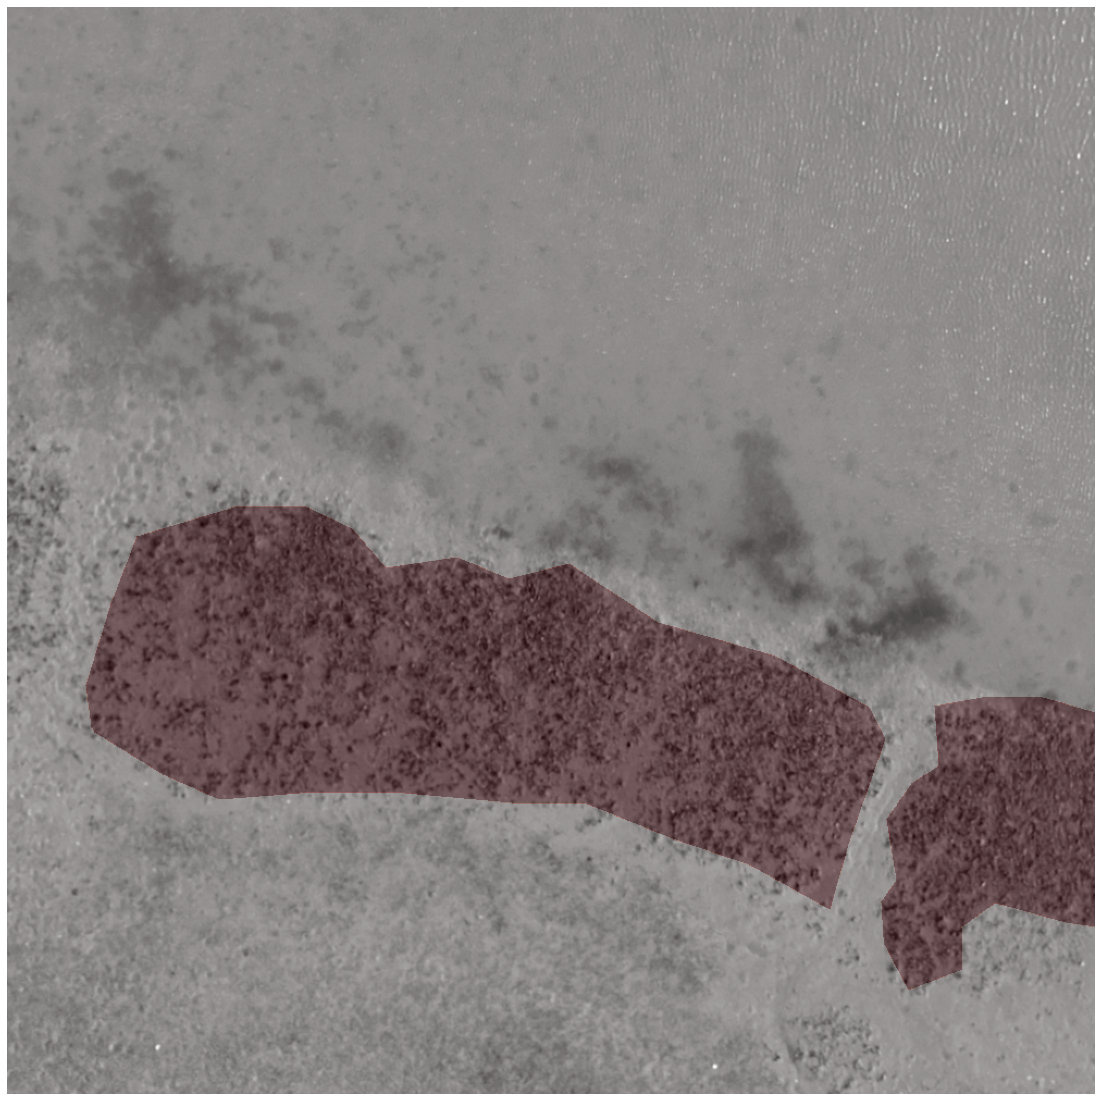

In [0]:
plt.figure(figsize=(20,20))
plt.imshow(image[:,:,0], cmap=plt.cm.gray)
plt.imshow(mask, alpha=0.25, cmap=plt.cm.Reds)
plt.axis('off')

### Reading and visualizing the tiles


Now we have prototyped the workflow, we need to define a function and work with each image and its label in a loop

The function below just collates the code in individual cells above

In [0]:
def get_image_mask_pair(a):

  if type(a['regions']) is dict:
      polygons = [r['shape_attributes'] for r in a['regions'].values()]
  else:
      print('in the dict type')
      polygons = [r['shape_attributes'] for r in a['regions']] 

  image_path = os.path.join(data_dir, a['filename'])
  image = skimage.io.imread(image_path)
  height, width = image.shape[:2]

  # Convert polygons to a bitmap mask of shape
  # [height, width, number of polygons]
  info = a['filename']
  mask = np.zeros([height, width, len(polygons)],dtype=np.uint8)

  for i, p in enumerate(polygons):
      # Get indexes of pixels inside the polygon and set them to 1
      rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
      mask[rr, cc, i] = 1

  mask = mask.astype(np.int) #, np.ones([mask.shape[-1]], dtype=np.int)
  mask = np.sum(mask, axis=2)
  return image, mask

So now we can acheive the same as the above, with any arbitrary annotation

(-0.5, 999.5, 999.5, -0.5)

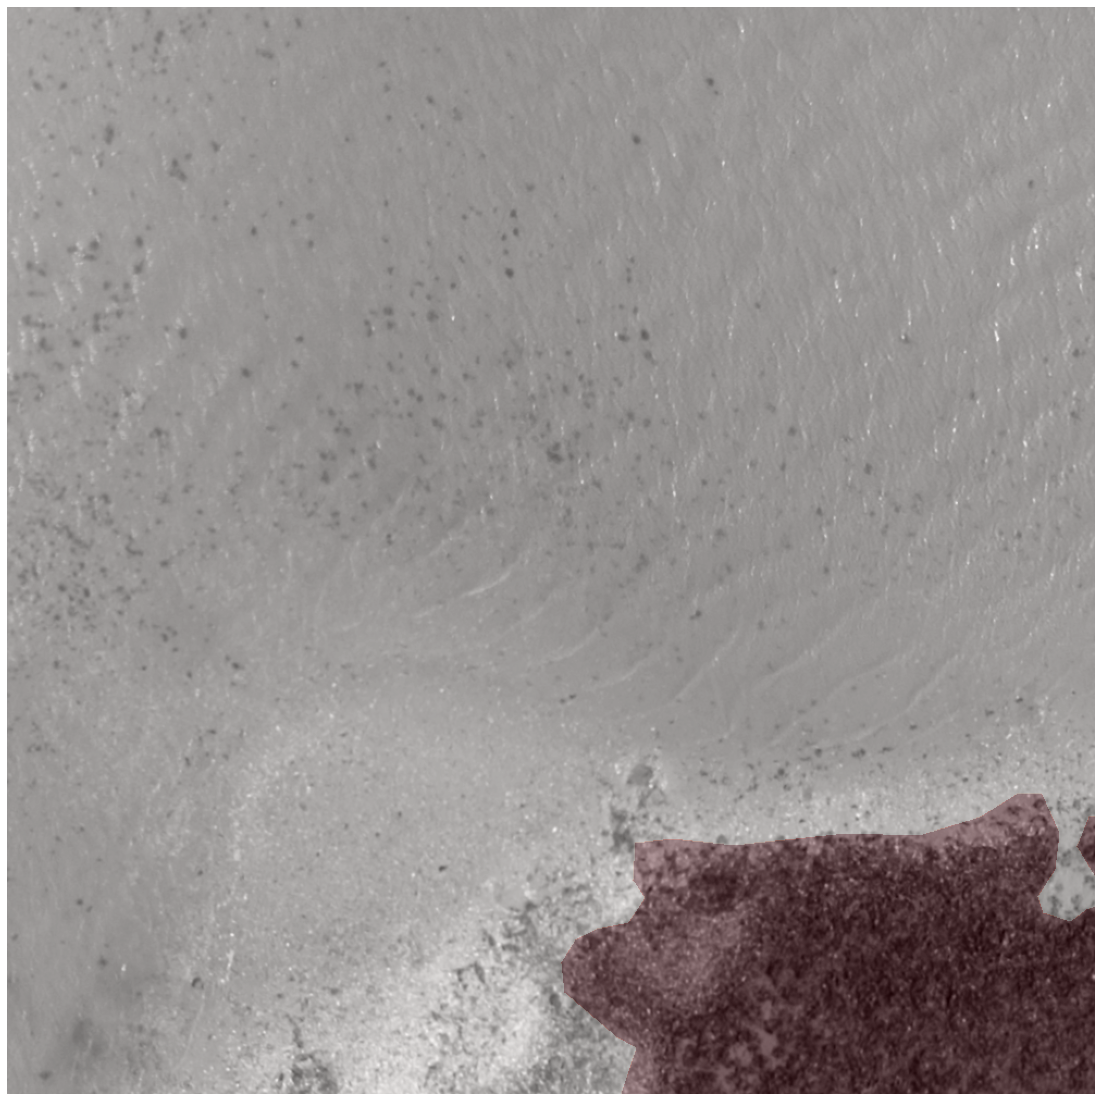

In [0]:
image, mask = get_image_mask_pair(test_annotations[25])

plt.figure(figsize=(20,20))
plt.imshow(image[:,:,0], cmap=plt.cm.gray)
plt.imshow(mask, alpha=0.25, cmap=plt.cm.Reds)
plt.axis('off')

which further means we now have a way to generate random batches of images and masks too

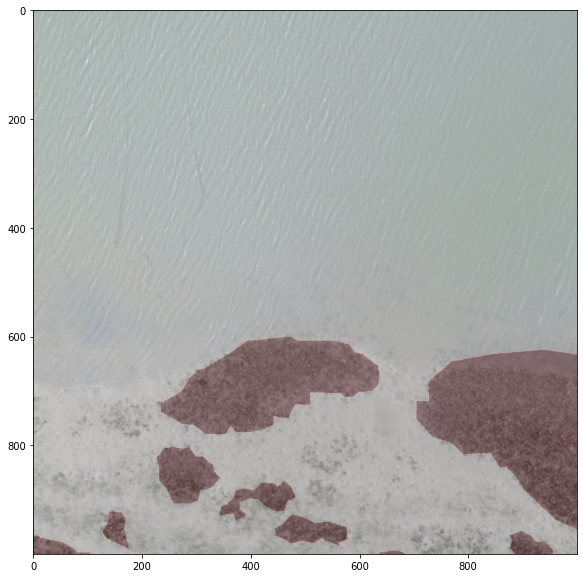

In [0]:
train_idx = np.random.choice(np.arange(len(test_annotations)), size= 1 , replace=False)[0]

image, mask = get_image_mask_pair(test_annotations[train_idx])

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.imshow(mask, alpha=0.25, cmap=plt.cm.Reds)

Now we have a workflow, we can test with the train and validation portions too

In [0]:
data_dir = "1kx1k_dataset/train"
train_annotations = json.load(open(os.path.join(data_dir, "via_region_data.json")))
train_annotations = list(train_annotations.values()) 

In [0]:
data_dir = "1kx1k_dataset/val"
val_annotations = json.load(open(os.path.join(data_dir, "via_region_data.json")))
val_annotations = list(val_annotations.values()) 

Let's see how many train, validation and test images and masks we have to work with

In [0]:
print("# test files: %i" % (len(test_annotations)))
print("# train files: %i" % (len(train_annotations)))
print("# validation files: %i" % (len(val_annotations)))

# test files: 163
# train files: 527
# validation files: 130


Finally, let's make a few plots to visualize some more of the validation samples

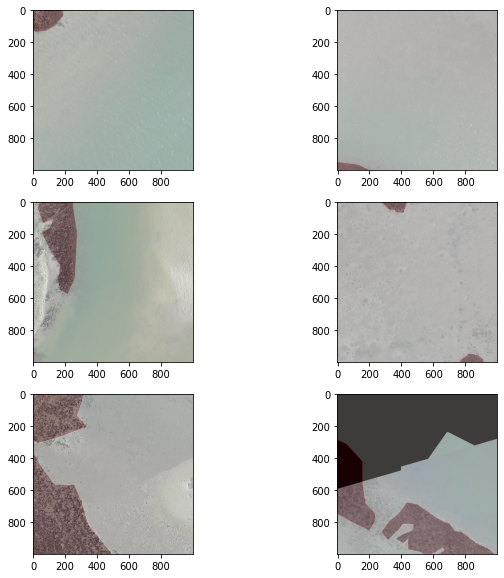

In [0]:
val_idx = np.random.choice(np.arange(len(val_annotations)), size= 6 , replace=False)

plt.figure(figsize=(10,10))
for k in range(len(val_idx)):
   image, mask = get_image_mask_pair(val_annotations[val_idx[k]])
   plt.subplot(3,2,k+1)
   plt.imshow(image)
   plt.imshow(mask, alpha=0.25, cmap=plt.cm.Reds)

and, for completeness, the test data

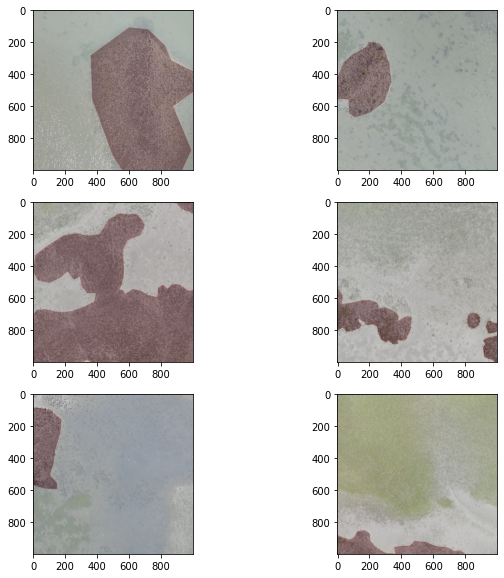

In [0]:
test_idx = np.random.choice(np.arange(len(test_annotations)), size= 6 , replace=False)

plt.figure(figsize=(10,10))
for k in range(len(test_idx)):
   image, mask = get_image_mask_pair(test_annotations[test_idx[k]])
   plt.subplot(3,2,k+1)
   plt.imshow(image)
   plt.imshow(mask, alpha=0.25, cmap=plt.cm.Reds)

To recap, we have

1. downloaded the dataset
2. created functions to read annotation data
3. created functions to create and visualize pairs of images and associated labels (masks)

Now we are ready to use this data to train a model to perform binary segmentation with these data. See you in the next lesson!

This jupyter notebook running on Google Colab is part of the "Advanced Binary Image Segmentation for the Geo- and Eco-sciences, using Deep Learning" course. The main course website can be accessed [here](https://mardascience.gitlab.io/binary_image_segmentation_for_geosciences/#/)